# 基于scikit-learn对Fashion MNIST数据集合进行分类并可视化

## 一、导入必要的库
基于sckit-learn实现导入必要的库

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

## 二、读取训练集和测试集数据

### （一）数据集介绍
Fashion-MNIST是Zalando的图像数据集，由一个包含60000个示例的训练集和一个包含10000个示例的测试集组成。每个示例都是一个28x28的灰度图像，与来自10个类的标签相关联。

每张图像的高度为28像素，宽度为28像素，总共784像素。每个像素都有一个与之关联的像素值，表示该像素的亮度或暗度，数字越高表示越暗。此像素值是介于0和255之间的整数。训练和测试数据集有785列。第一列由类标签组成，代表服装。其余列包含关联图像的像素值。

为了在图像上找到一个像素，假设我们已经将x分解为x=i*28+j，其中i和j是介于0和27之间的整数。像素位于28x28矩阵的第i行和第j列上。例如，pixel31表示位于左起第四列（即j=3)和从上起第二行(即i=1)的像素。
    
每个训练集和测试集示例都分配给以下标签之一：

    0：T恤    1：裤子    2：套头衫    3：连衣裙    4：外套   5：凉鞋    6：衬衫    7：运动鞋    8：包    9：短靴

In [6]:
# 读取训练集和测试集
train_data = pd.read_csv('data/fashion-mnist_train.csv')
test_data = pd.read_csv('data/fashion-mnist_test.csv')

# 显示训练集和测试集的前几行
print("Training Data:")
print(train_data.head())
print("\nTesting Data:")
print(test_data.head())

Training Data:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0    

从训练集和测试集数据中可以印证前面的数据集介绍，即：

    1、数据集列由label标签和像素点组成
    
    2、其中label标签指示分类，像素点组成一张图片
    
    3、数据集中共有10个分类，图片像素为28x28

## 三、数据预处理与准备工作

### （一） 数据预处理
将训练集和测试集的特征提取到X_train和X_test再由模型进行学习和预测。在FASHOIN MNIST数据集中，特征是28x28的像素值，表示Fashion-MNIST中的服装图像

同时将训练集和测试集的标签提取到y_train和y_test，是模型要预测的目标输出。在FASHOIN MNIST数据集中，该标签即指服装的类别

最后将像素值从0到255缩放到0到1，所有特征（像素值）将具有相同的数值范围，有助于提高模型的收敛速度，使模型更容易学习

In [10]:
# 提取训练集特征和标签
X_train = train_data.drop('label', axis=1).values  # 特征
y_train = train_data['label'].values  # 标签

# 提取测试集特征和标签
X_test = test_data.drop('label', axis=1).values  # 特征
y_test = test_data['label'].values  # 标签

# 将数据标准化到0到1之间
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

以上数据处理基于Scikit-learn 适用于分类方法1-6

In [12]:
# 用于改进分类方法8——CNN
# 重塑数据为CNN输入格式 [样本数, 通道数, 高度, 宽度] 输入是28x28的灰度图像
img_size = int(np.sqrt(X_train.shape[1]))  # 计算图像尺寸
CNN_X_train = X_train.reshape(-1, 1, img_size, img_size)
CNN_X_test = X_test.reshape(-1, 1, img_size, img_size)

# 转换为PyTorch张量
X_train_tensor = torch.from_numpy(CNN_X_train)
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(CNN_X_test)
y_test_tensor = torch.from_numpy(y_test).long()

# 创建数据加载器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

以上数据处理基于torch 适用于改进分类方法CNN

### （二）分类图像

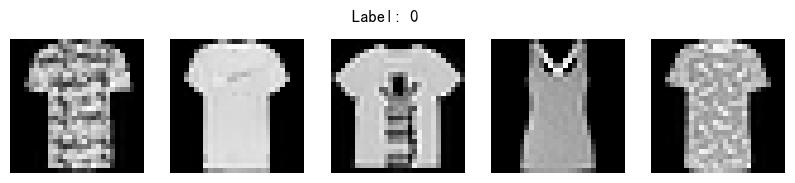

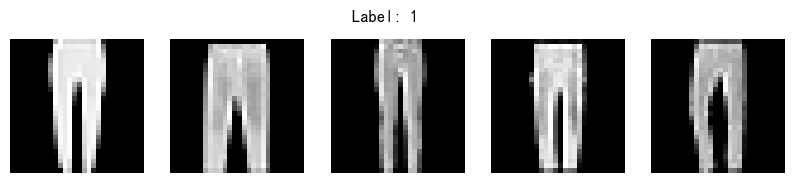

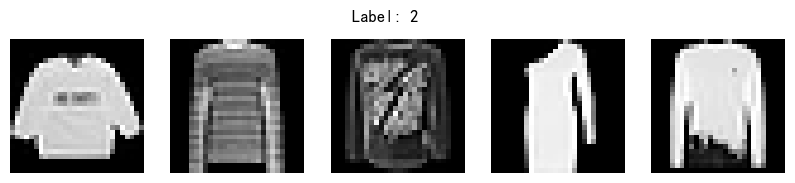

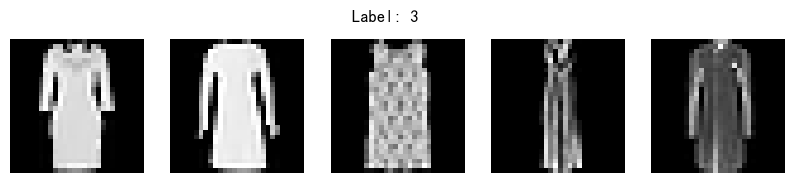

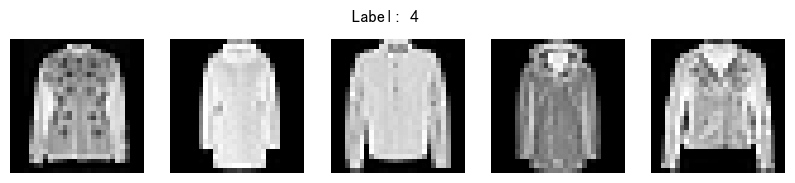

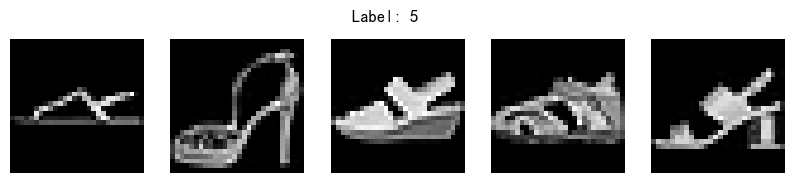

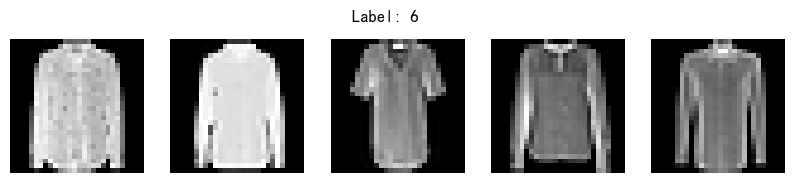

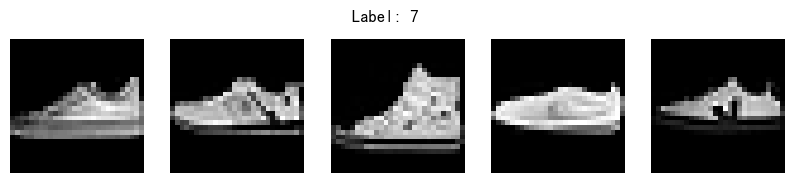

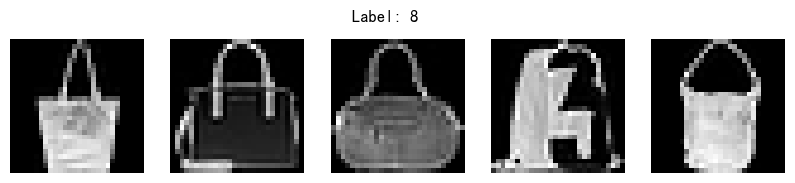

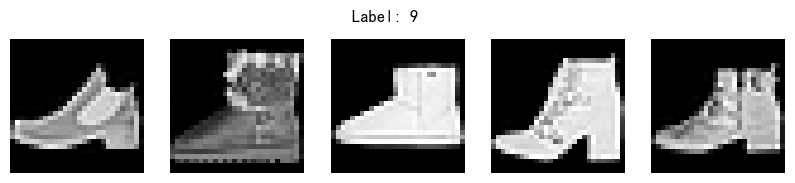

In [15]:
# 显示每个标签的几张图像
def display_images_per_label(X, y, num_images=5):
    label_set = np.unique(y)  # 获取所有标签
    for label in label_set:
        indices = np.where(y == label)[0][:num_images]  # 获取该标签的前num_images个索引
        plt.figure(figsize=(10, 2))
        
        for i, idx in enumerate(indices):
            plt.subplot(1, num_images, i + 1)
            plt.imshow(X[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
        
        plt.suptitle(f'Label: {label}')
        plt.show()

# 调用函数显示每个标签的5张图像
display_images_per_label(X_train, y_train, num_images=5)

特别地，从打印的数据集图片中我们可以发现label2、4、6的区别似乎有些模棱两可，这里的分类仅作为简单参考。同时，观察这些图片还可以发现label6打印的图片中的第3个似乎有分类错误

### （四）结果输出及对比的准备

In [18]:
# Fashion-MNIST 标签对应的服装类别
label_list = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'boot']

利用label_list列表存储0-9对应的服装类型 便于后续使用

In [20]:
models_name = ["RandomForest", "LogesticRegression", "SVM", "DecisionTree", "MLP", "KNC", "voting_clf", "Pytorch_CNN"]
results = {}

利用models_name保存用到的分类方法 便于比较结果（利用result存储）

In [22]:
# 模型训练完成后打印分类报告
def printClassificationReport(name, accuracy):
    # 分类报告
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    results[name] = {
        "accuracy": accuracy
    }
    
# 打印混淆矩阵
def printConfusionMatrix(name,writer,cm):
    # 可视化混淆矩阵
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    plt.title(f'Confusion Matrix - {name} - {writer}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    filename = "./images/ConfusionMatrixes/" + name + "_ConfusionMatrix.png"
    plt.savefig(filename)
    plt.show()

定义printClassificationReport函数和printConfusionMatrix函数用于打印分类报告和可视化混淆矩阵，减少代码重复

## 四、多种分类模型的实现

### （一）随机森林模型
随机森林是一种以决策树为基础的集成学习模型，它的核心运作方式是通过组合多个决策树来进行预测，以此提升模型的预测准确性与稳定性。随机森林从训练数据中采用有放回的随机抽样方式，抽取多个不同的子集，然后针对每个子集分别训练出一棵决策树，最后综合这些决策树的预测结果得出最终判断。对于分类任务，随机森林通常采用投票的方式，也就是将得票数量最多的类别确定为预测结果；而对于回归任务，一般采用平均法，将所有决策树的预测值进行平均，以此作为最终的预测结果。

从优点来看，随机森林具有较高的预测准确率，能够有效处理高维数据，对于数据中存在的缺失值不敏感，并且不容易出现过拟合的问题，同时还具备评估特征重要性的能力，帮助理解数据中不同特征对预测结果的影响程度。不过，它也存在一些缺点，比如在训练和预测阶段运行速度相对较慢，模型结构较为复杂，在解释模型如何做出决策时相对困难，可解释性较差。

<div align = "center"><img src="./images/RandomForest_principle.png" width="450" height="300"> </div>
<div align = "center">随机森林原理（黄旭东2023217466）</div>  

在使用scikit - learn库调用随机森林模型时，需要导入 RandomForestClassifier 模块，具体代码为 from sklearn.ensemble import RandomForestClassifier ；若是处理回归任务，则应导入 RandomForestRegressor 模块，即 from sklearn.ensemble import RandomForestRegressor 。接下来要创建模型对象，代码 RandomForestModel = RandomForestClassifier(n_estimators = 100, random_state = 42) 用于创建模型。其中， n_estimators 参数指定了构成随机森林的决策树数量，这里设置为100棵； random_state 用于设置随机种子，确保每次运行代码时模型的训练和预测结果一致，具有可重现性。

训练阶段，使用 fit 方法进行训练，如 RandomForestModel.fit(X_train, y_train) 。其中， X_train 代表训练集的特征数据，是模型学习的依据； y_train 代表训练集的标签数据，告知模型正确的结果，让模型通过学习特征与标签的对应关系来提升预测能力。训练好模型后，使用 predict 方法进行预测，例如 y_pred = RandomForestModel.predict(X_test) ， X_test 是测试集的特征数据，模型会根据训练学到的规律对其进行预测，预测结果保存在 y_pred 中。

最后是评估模型，可以使用 accuracy_score 等函数来计算准确率等指标评估模型性能，比如 accuracy = accuracy_score(y_test, y_pred) ，通过对比测试集真实标签 y_test 和模型预测结果 y_pred ，得出模型预测的准确程度

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.80      0.80      0.80      1000
           3       0.89      0.94      0.91      1000
           4       0.80      0.86      0.83      1000
           5       0.98      0.95      0.96      1000
           6       0.75      0.61      0.67      1000
           7       0.92      0.94      0.93      1000
           8       0.95      0.97      0.96      1000
           9       0.94      0.95      0.94      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



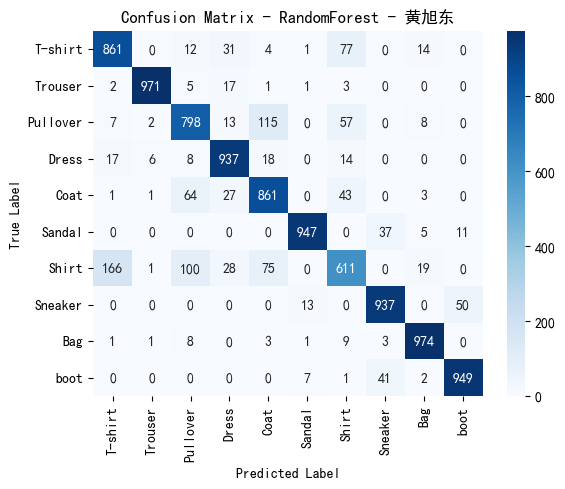

In [26]:
# 创建随机森林分类器
name = "RandomForest"
writer ="黄旭东"
RandomForestModel = RandomForestClassifier(n_estimators=100, random_state=42)

# 训练模型
RandomForestModel.fit(X_train, y_train)

# 进行预测
y_pred = RandomForestModel.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 打印分类报告及可视化混淆矩阵
printClassificationReport(name, accuracy)
cm = confusion_matrix(y_test, y_pred)
printConfusionMatrix(name, writer, cm)

### （二）逻辑回归模型
逻辑回归是机器学习中一种经典的分类模型，它基于线性回归，通过引入sigmoid函数将线性回归的结果映射到[0,1]区间，从而实现分类功能。sigmoid函数包含特征权重向量，输入特征向量以及偏置项。在模型训练时通常采用最大似然估计来确定模型的参数w和b。通过定义损失函数，使用梯度下降等优化算法来最小化损失函数，从而得到最优的参数。

在使用过程中，线性回归模型简单，易于理解和实现，并且计算成本低，训练速度快，能够通过特征的权重来分析其对分类结果的影响。但是对于非线性数据的拟合能力有限，对数据中的噪声较为敏感。当类别分布不均衡时，模型容易偏向于多数类。广泛应用于二分类问题，如疾病诊断（判断是否患病）、信用评估（判断用户是否会违约）、垃圾邮件分类等。对于多分类问题，逻辑回归模型常使用“一对多”的方法进行多次分类。sigmoid函数及“一对多”分类如下图。

<table>
    <td><img src="./images/LogisticRe_sigmoid.png" width="450" height="300"> </td>
    <td><img src="./images/Logistic_Re_MultiClassifier.png" width="450" height="300"></td>
</table>
<div align = "center">sigmoid函数图及“一对多”分类图（胡锦康2023217473）</div>
<div></div>  

在sckitlearn中，通过LogisticRegression用于创建逻辑回归模型。参数 max_iter=1000 设置了最大迭代次数，确保模型有足够的时间进行优化。随后通过调用fit方法对模型进行训练。输入特征矩阵 X_train 和对应的标签向量 y_train 被传递给模型。然后模型通过梯度下降或其他优化算法调整参数 (w) 和 (b)，以最小化损失函数。下一步使用训练好的模型对测试集 X_test 进行预测，并输出模型的分类准确率。此外，分类报告包括精确率（Precision）、召回率（Recall）、F1分数等指标。混淆矩阵则显示了不同类别之间的分类结果分布。

综合看来，逻辑回归通过训练过程拟合输入特征与标签之间的关系拟合数据，用Sigmoid 函数将线性组合的结果映射到 [0, 1] 区间，表示属于某一类别的概率，来拟合数据，最后是分类决策，根据概率值与阈值的比较，确定最终的类别标签。

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80      1000
           1       0.95      0.97      0.96      1000
           2       0.77      0.76      0.77      1000
           3       0.86      0.86      0.86      1000
           4       0.78      0.81      0.79      1000
           5       0.93      0.91      0.92      1000
           6       0.65      0.60      0.62      1000
           7       0.90      0.92      0.91      1000
           8       0.94      0.94      0.94      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



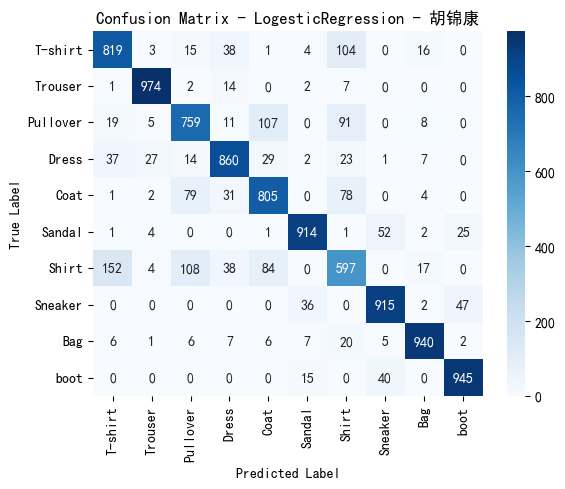

In [28]:
# 创建逻辑回归分类器
name = "LogesticRegression"
writer = "胡锦康"
LogisticRegressionModel = LogisticRegression(max_iter=1000)

# 训练模型
LogisticRegressionModel.fit(X_train, y_train)

# 进行预测
y_pred = LogisticRegressionModel.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 打印分类报告及可视化混淆矩阵
printClassificationReport(name, accuracy)
cm = confusion_matrix(y_test, y_pred)
printConfusionMatrix(name, writer, cm)

### （三）支持向量机（SVM）
支持向量机（Support Vector Machine, SVM）是一类按监督学习方式对数据进行二元分类的广义线性分类器，其决策边界是对学习样本求解的最大边距超平面。

<div align = "center"><img src="./images/SVM_principle.png" width="450" height="300"> </div>
<div align = "center">SVM原理（邓旭松2023217484）</div>  

SVM使用铰链损失函数计算经验风险并在求解系统中加入了正则化项以优化结构风险，是一个具有稀疏性和稳健性的分类器 。SVM可以通过核方法进行非线性分类，是常见的核学习方法之一 。
1. 线性可分场景：最大间隔分类
假设数据在原始特征空间中线性可分，SVM 通过最大化两类样本到超平面的最小距离（即 “间隔”）构建分类器。如图 1 所示，超平面（实线）将两类样本（圆形与三角形）分开，间隔由离超平面最近的样本点（支持向量，空心标记）决定。
2. 非线性场景：核函数映射
若数据非线性可分，SVM 通过核函数将样本映射到高维空间，使数据在高维空间中线性可分。常用核函数包括：
线性核（Linear Kernel）：直接在原始空间计算内积，适用于高维线性可分数据（如 Fashion-MNIST 的 784 维像素特征）。
径向基核（RBF Kernel）：通过高斯函数映射到无限维空间，捕捉非线性模式。
多项式核（Polynomial Kernel）：通过多项式函数实现非线性映射。
支持向量机通过线性核在 Fashion-MNIST 数据集上实现了高效的高维特征分类，虽在复杂非线性场景中表现略逊于深度学习模型，但其理论基础扎实、计算效率高，适用于小样本高维数据的快速分类任务。通过可视化混淆矩阵和准确率对比，可清晰定位模型不足，为后续优化提供方向。

Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1000
           1       0.96      0.97      0.97      1000
           2       0.78      0.76      0.77      1000
           3       0.87      0.88      0.88      1000
           4       0.79      0.80      0.79      1000
           5       0.94      0.92      0.93      1000
           6       0.67      0.61      0.64      1000
           7       0.90      0.92      0.91      1000
           8       0.96      0.93      0.95      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



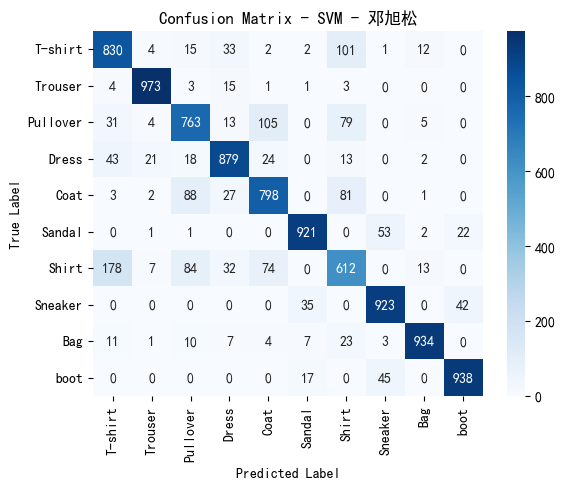

In [30]:
# 创建支持向量机分类器
name = "SVM"
writer = "邓旭松"
SVC_Model = SVC(kernel='linear', random_state=42)

# 训练模型
SVC_Model.fit(X_train, y_train)

# 进行预测
y_pred = SVC_Model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 打印分类报告及可视化混淆矩阵
printClassificationReport(name, accuracy)
cm = confusion_matrix(y_test, y_pred)
printConfusionMatrix(name, writer, cm)

### （四）决策树
决策树（Decision Tree）是一种树形结构的分类器，通过对实例的特征进行逐层测试来进行分类。在机器学习中，决策树是一个预测模型，他代表的是对象属性与对象值之间的一种映射关系。每个内部节点是一个特征上的条件判断，每个分支是判断结果，每个叶节点是分类结果。

决策树的核心思想是通过递归划分特征空间，使每个子区域的纯度最大化。

纯度的常用度量指标有：

    Gini 不纯度（默认）：衡量随机选择样本被错误分类的概率；
    信息增益（使用 entropy）：基于信息论中的熵减少量；

<div align = "center"><img src="./images/DecisionTree_exp.png" width="450" height="300"> </div>
<div align = "center">决策树示例（吕宣霖2023217471）</div>  
<div> </div>
在该项目的实现中，首先创建决策树分类器，通过DecisionTreeClassifier (random_state=42)初始化分类器，这里设置随机种子为 42 是为了保证每次运行结果的可复现性，其默认使用 Gini 不纯度作为划分标准来构建决策树。用fit (X_train, y_train)语句使用训练数据及其对应的标签对模型进行训练，训练过程是决策树通过递归地选择能最大化纯度提升的最优特征持续划分，直至满足停止条件。之后用predict (X_test)对测试数据进行类别预测，预测时每个测试样本会从根节点开始依据特征判断，沿着相应分支遍历直至到达叶节点输出对应的类别标签。通过accuracy_score (y_test, y_pred)计算预测准确率。

Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1000
           1       0.94      0.96      0.95      1000
           2       0.69      0.68      0.69      1000
           3       0.82      0.81      0.82      1000
           4       0.68      0.69      0.68      1000
           5       0.90      0.87      0.88      1000
           6       0.55      0.56      0.56      1000
           7       0.85      0.86      0.86      1000
           8       0.91      0.90      0.91      1000
           9       0.88      0.90      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



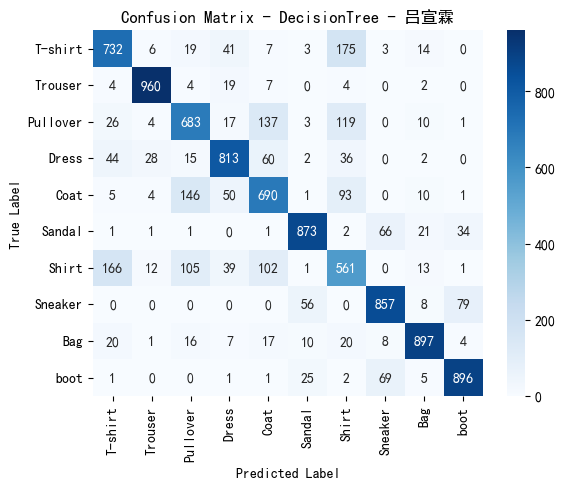

In [32]:
# 创建决策树分类器
name = "DecisionTree"
writer = "吕宣霖"
DecisionTreeModel = DecisionTreeClassifier(random_state=42)

# 训练模型
DecisionTreeModel.fit(X_train, y_train)

# 进行预测
y_pred = DecisionTreeModel.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 打印分类报告及可视化混淆矩阵
printClassificationReport(name, accuracy)
cm = confusion_matrix(y_test, y_pred)
printConfusionMatrix(name, writer, cm)

### （五）多层感知机MLP
MLP（Multi-Layer Perceptron，多层感知机）是一种基于神经网络的监督学习模型，属于前馈神经网络的一种。它通过多层非线性神经元的组合，能够学习输入数据中的复杂非线性关系，常用于分类和回归任务。

其核心组成包括：

    输入层：接收原始数据，神经元数量等于输入特征维度。
    隐藏层：由多层神经元组成，每层神经元通过权重与前一层连接，引入非线性激活函数（如 ReLU、Sigmoid、Tanh）打破线性关系。
    输出层：根据任务类型决定激活函数和神经元数量，对于分类任务通常用 Softmax 激活函数，输出类别概率。对于回归任务常用线性激活函数，输出连续值。
<div align="center"><img src="./images/MLP_principle.png" width="450" height="300"></div>
<div align="center">多层感知机原理（叶文杰2023217477）</div>

工作机制包含：

    前向传播：输入数据通过各层权重矩阵和激活函数逐层计算，得到输出预测值。
    反向传播：通过损失函数（如交叉熵、均方误差）计算预测值与真实值的误差，利用梯度下降算法更新各层权重，最小化损失。

该项目的实现中，MLP利用scikit-learn中的MLPClassifier实现，调用MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

其中参数:

    hidden_layer_sizes为隐藏层结构，这里(100,)指1层100个神经元的隐藏层；activation隐藏层激活函数，这里默认为relu；
    
    solver优化器，这里默认为adam; alphaL2正则化系数，防止过拟合，这里默认为0.0001；learning_rate学习率，这里默认为adaptive；
    
    max_iter最大迭代次数，这里为1000；random_state随机种子，确保结果可复现，这里为42；

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1000
           1       0.98      0.99      0.98      1000
           2       0.84      0.77      0.80      1000
           3       0.94      0.83      0.88      1000
           4       0.74      0.93      0.82      1000
           5       0.96      0.96      0.96      1000
           6       0.78      0.62      0.69      1000
           7       0.95      0.94      0.94      1000
           8       0.97      0.96      0.96      1000
           9       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



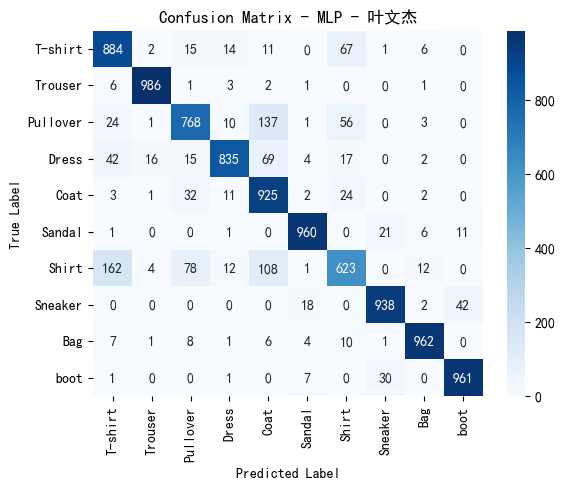

In [34]:
# 创建神经网络分类器
name = "MLP"
writer = "叶文杰"
MLP_Model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

# 训练模型
MLP_Model.fit(X_train, y_train)

# 进行预测
y_pred = MLP_Model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 打印分类报告及可视化混淆矩阵
printClassificationReport(name, accuracy)
cm = confusion_matrix(y_test, y_pred)
printConfusionMatrix(name, writer, cm)

### （六）K近邻（K - Nearest Neighbors，KNC）
K 近邻算法是一种基于实例的有监督机器学习算法，属于惰性学习方法。它不基于任何显式的模型训练，而是在预测阶段通过衡量数据点之间的距离来进行决策，常用于分类和回归任务，在分类问题中应用更为广泛。

#### 核心原理
给定一个训练数据集，对新的输入实例，在训练数据集中找到与该实例最邻近的 K 个实例， 这 K 个实例的多数属于某个类，就把该输入实例分类到这个类中。

<div align="center"><img src="./images/KNC_exp.png" width="450" height="300"></div>
<div align="center">KNC数据集示例（鲁田鑫2023217464）</div>

比如我们的输入样本是图中的蓝色，那么k个近邻就是距离绿色小圆最近的k个邻居，然后在这k个邻居中，若黑色小圆的数量多于红色小圆，那么输入样本的属性就与蓝黑色小圆相同，反之则与红色小圆的属性相同，这就是k-近邻算法的算法思想。

这里的 “邻近” 通过距离度量来确定，常见的距离度量方法有欧氏距离、曼哈顿距离等。以欧氏距离为例，对于两个 n 维向量 x = (x1,x2,...,xn) 和 y = (y1,y2,...,yn)，它们之间的欧氏距离d(x,y)计算公式为：
<div align="center"><img src="./images/KNC_distance.png" width="200" height="50"></div>

#### 算法流程
K 近邻算法的流程为：首先计算待预测样本与训练集中每个样本的距离，以此衡量样本间的相似性；接着按照距离大小进行排序，从中选取距离最近的 K 个样本，形成待预测样本的近邻集合；然后统计这 K 个近邻样本中每个类别的出现数量；最后将待预测样本归为出现数量最多的类别，完成分类预测。  

在 scikit-learn 中实现 K 近邻算法，构建模型时，使用KNeighborsClassifier 类，其中关键参数n_neighbors 用于确定 K 值，即参与预测的最近邻居数量。比如设置n_neighbors=5 ，就表示寻找 5 个最近邻居。模型构建好后，通过fit 方法传入训练集数据，虽 KNN “训练” 只是存储数据，但这一步必不可少。预测阶段，用训练好的模型调用predict 方法对测试集数据进行预测。预测后，用accuracy_score 等评估指标衡量模型性能，还可借助混淆矩阵、分类报告等更细致了解模型在不同类别上的表现。若想获取样本属于各类别的概率，可调用predict_proba 方法。整个过程简单直接，能快速实现 K 近邻算法用于分类任务。

Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82      1000
           1       0.99      0.96      0.98      1000
           2       0.75      0.81      0.78      1000
           3       0.91      0.88      0.90      1000
           4       0.79      0.80      0.79      1000
           5       1.00      0.82      0.90      1000
           6       0.68      0.58      0.63      1000
           7       0.87      0.94      0.91      1000
           8       0.98      0.95      0.97      1000
           9       0.88      0.96      0.92      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



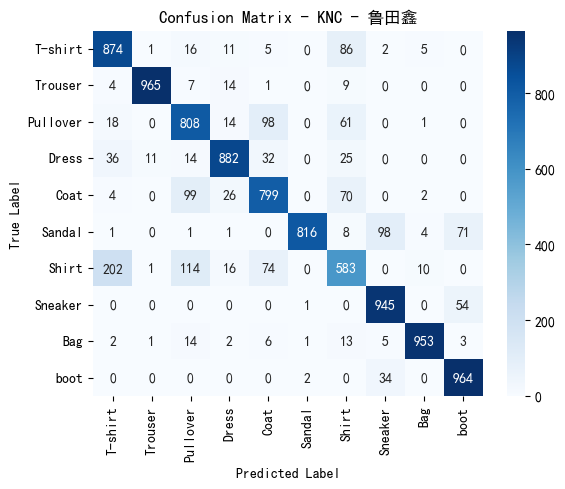

In [36]:
# 创建K-近邻分类器
name = "KNC"
writer = "鲁田鑫"
KNC_Model = KNeighborsClassifier(n_neighbors=5)

# 训练模型
KNC_Model.fit(X_train, y_train)

# 进行预测
y_pred = KNC_Model.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# 打印分类报告及可视化混淆矩阵
printClassificationReport(name, accuracy)
cm = confusion_matrix(y_test, y_pred)
printConfusionMatrix(name, writer, cm)

上述方法是基于scikit-learn中KNeighborClassifier方法实现的，在结果表现上较为简单。

下面的方法同样利用了KNeighborClassifier方法，更为详细地使用，同时输出了学习曲线、ROC曲线、验证曲线、决策边界等信息，对KNC模型的评估更加具体。

正在生成KNN模型评估可视化图表...


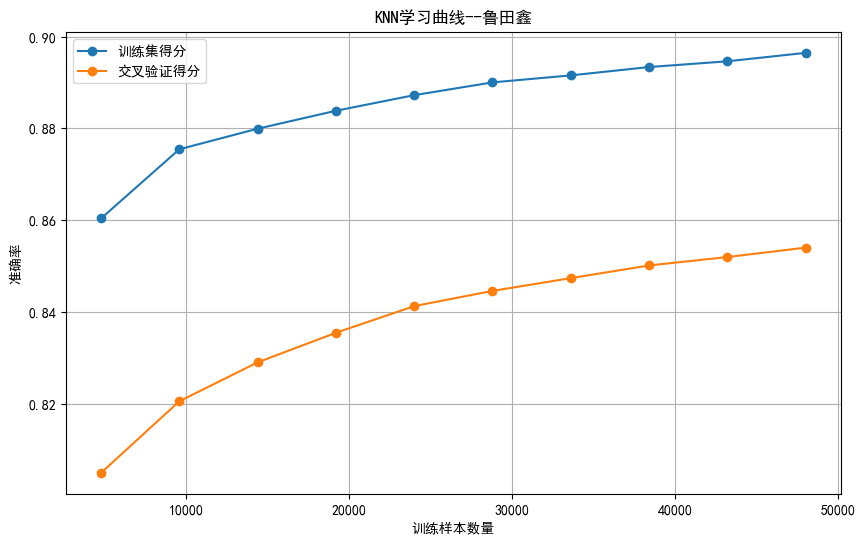

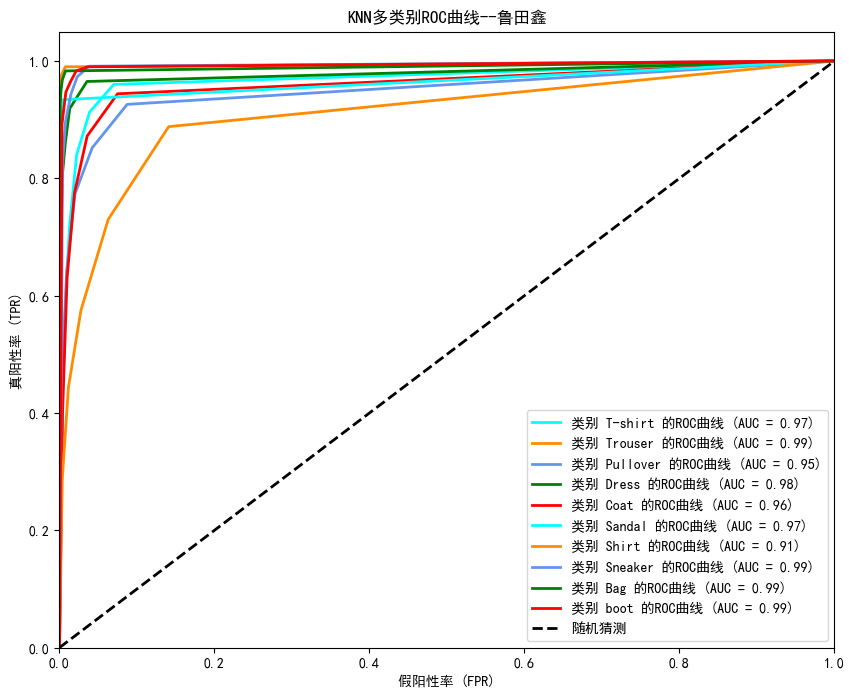

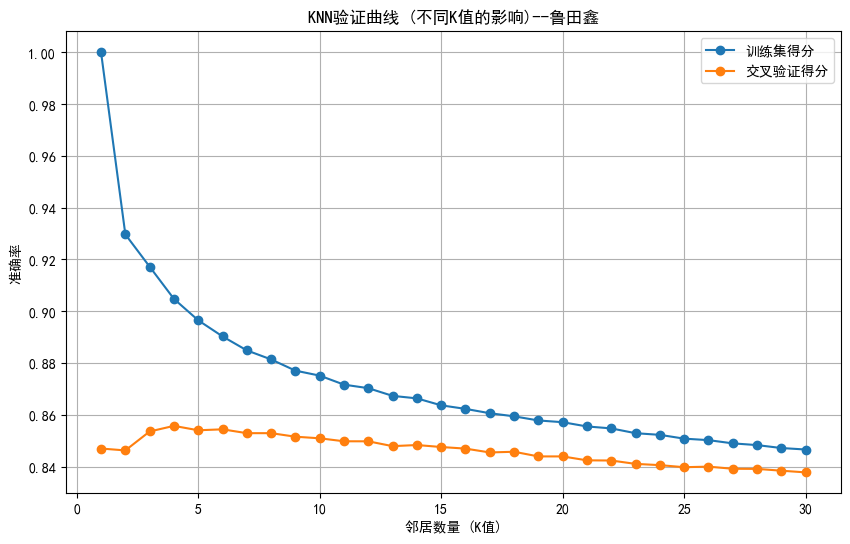

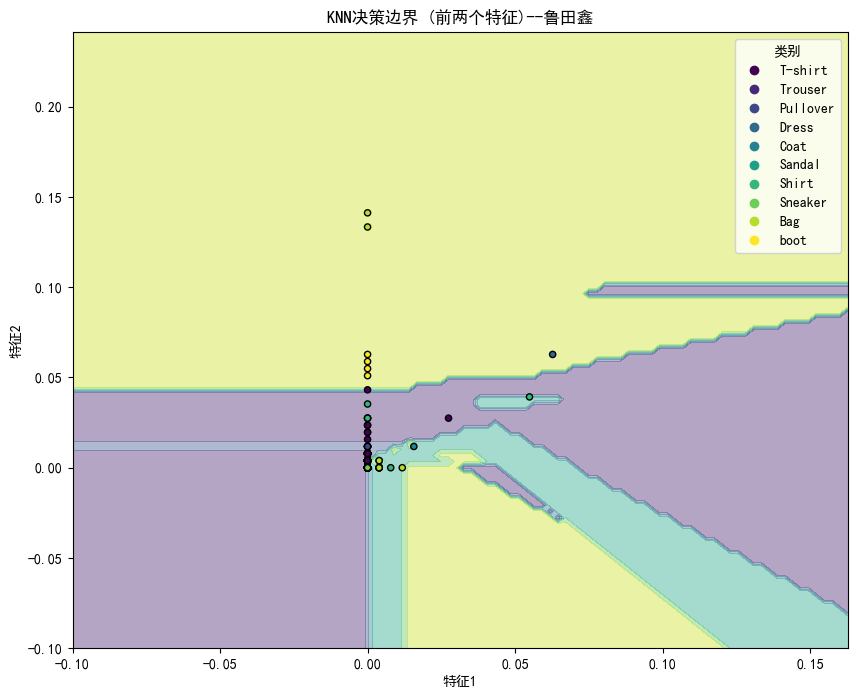

所有可视化图表生成完成！


In [38]:
# 1. 学习曲线
def plot_learning_curve():
    train_sizes, train_scores, test_scores = learning_curve(
        KNeighborsClassifier(n_neighbors=5), X_train, y_train, cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='训练集得分')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='交叉验证得分')
    plt.title('KNN学习曲线--鲁田鑫')
    plt.xlabel('训练样本数量')
    plt.ylabel('准确率')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# 2. ROC曲线（多类情况）
def plot_roc_curve():
    try:
        # 二值化标签
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        n_classes = y_test_bin.shape[1]
        
        # 预测概率
        y_score = KNC_Model.predict_proba(X_test)
        
        # 计算每一类的ROC
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # 绘制所有类的ROC曲线
        plt.figure(figsize=(10, 8))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label='类别 {0} 的ROC曲线 (AUC = {1:0.2f})'
                     ''.format(label_list[i], roc_auc[i]))
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='随机猜测')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('假阳性率 (FPR)')
        plt.ylabel('真阳性率 (TPR)')
        plt.title('KNN多类别ROC曲线--鲁田鑫')
        plt.legend(loc="lower right")
        plt.show()
    except Exception as e:
        print(f"绘制ROC曲线时出错: {str(e)}")

# 3. 验证曲线（不同K值的影响）
def plot_validation_curve():
    param_range = np.arange(1, 31)
    train_scores, test_scores = validation_curve(
        KNeighborsClassifier(), X_train, y_train, 
        param_name="n_neighbors", param_range=param_range,
        cv=5, scoring="accuracy")
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), 'o-', label='训练集得分')
    plt.plot(param_range, np.mean(test_scores, axis=1), 'o-', label='交叉验证得分')
    plt.title('KNN验证曲线 (不同K值的影响)--鲁田鑫')
    plt.xlabel('邻居数量 (K值)')
    plt.ylabel('准确率')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# 4. 决策边界（使用前两个特征）
def plot_decision_boundary():
    # 只使用前两个特征
    X_train_2d = X_train[:, :2]
    X_test_2d = X_test[:, :2]
    
    # 重新训练模型
    knn_2d = KNeighborsClassifier(n_neighbors=5)
    knn_2d.fit(X_train_2d, y_train)
    
    # 创建网格
    x_min, x_max = X_train_2d[:, 0].min() - 0.1, X_train_2d[:, 0].max() + 0.1
    y_min, y_max = X_train_2d[:, 1].min() - 0.1, X_train_2d[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    # 预测整个网格
    Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 绘制决策边界
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    
    # 绘制训练点
    scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, 
                          cmap='viridis', edgecolor='k', s=20)
    
    plt.title('KNN决策边界 (前两个特征)--鲁田鑫')
    plt.xlabel('特征1')
    plt.ylabel('特征2')
    plt.legend(handles=scatter.legend_elements()[0], 
               labels=label_list, title="类别")
    plt.show()

# 运行所有可视化
print("正在生成KNN模型评估可视化图表...")
plot_learning_curve()
plot_roc_curve()
plot_validation_curve()
plot_decision_boundary()
print("所有可视化图表生成完成！")

## 五、模型改进与分析

### 错误样本分析

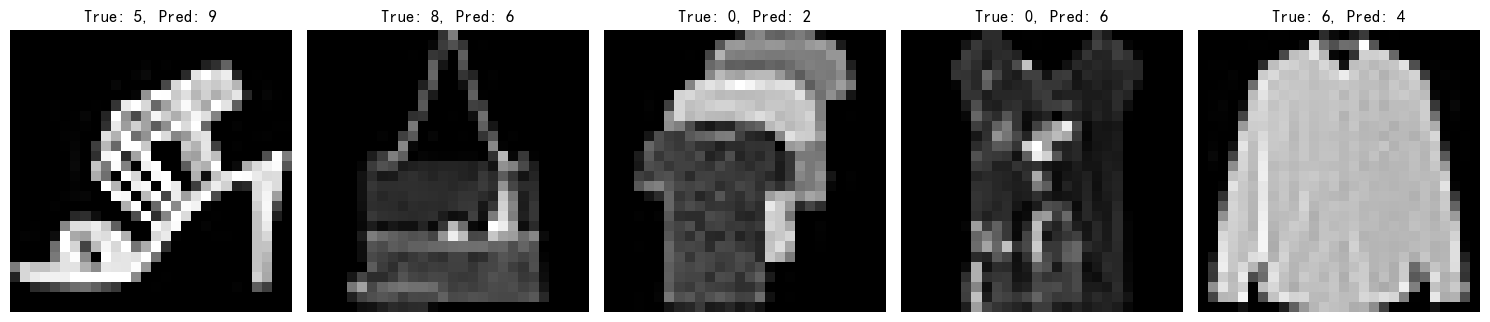

In [41]:
# 找到错误分类的样本
incorrect_indices = np.where(y_pred != y_test)[0]

# 随机选择5个错误分类的样本
if len(incorrect_indices) > 5:
    incorrect_indices = np.random.choice(incorrect_indices, 5, replace=False)

# 绘制错误分类的样本
plt.figure(figsize=(15, 5))
for i, idx in enumerate(incorrect_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_test[idx]}, Pred: {y_pred[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


从随机打印的错误样本以及第四部分多种分类模型的训练结果中我们不难发现，上述模型对于Shirt、coat、pullover的预测效果较差。  
从数据集上分析，在项目开头显示图像时我们就可以看出，Shirt、coat、pullover（即第6、4、2类）图像看起来相似度较大，差异不明显，给模型判断造成了困难。  
从训练模型上分析，第四部分中的分类模型都是比较基础的模型，这些模型对这种图像数据的分析有上限，表现较好的随机森林和MLP准确率达到0.88。

为了得到更高的准确率，我们尝试了几种方法，包括引入集成学习——投票法、基于Pytorch的CNN方法，同时尝试了对数据进行降维、对模型进行调参等方法。介绍如下，其中效果最好的是基于Pytorch的CNN方法，准确率可以达到0.92、0.93。

### 改进（一） 集成学习——投票法
投票法是集成学习中最基础且有效的策略之一，通过整合多个模型的预测结果，降低单一模型的偏差和方差，提升整体性能，其基本思想是 "集体智慧"。通过训练多个不同的基模型，对新样本进行预测时，综合所有基模型的输出，根据投票规则得出最终结果。投票法的有效性基于不同模型可能捕捉到数据的不同特征，组合后能减少错误。

投票策略包括：
    
    1. 硬投票（Hard Voting），即直接选择所有基模型预测结果中出现次数最多的类别。比较适用于分类任务，尤其是基模型预测结果较为一致时。
    2. 软投票（Soft Voting），即根据各基模型的预测概率进行加权平均，选择概率最高的类别。适用于能输出概率的基模型。这种方法考虑了预测的置信度，对分类边界模糊的样本更鲁棒。
    3. 加权投票（Weighted Voting），即为不同基模型分配权重，权重高的模型对最终结果影响更大。权重分配可基于模型在验证集上的性能或手动调整。
<div align="center"><img src="./images/VotingClf.png" width="450" height="300"></div>
<div align="center">投票法结构图</div>

scikit-learn中提供了VotingClassifier和VotingRegressor类，分别用于分类和回归任务。该项目，基于前面训练模型得到的准确率，我们选择了随机森林模型和多层感知机模型作为基模型，调用投票法模型时无需再次进行随机森林和多层感知机的训练。

Voting Classifier Accuracy: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1000
           1       0.98      0.99      0.98      1000
           2       0.84      0.78      0.81      1000
           3       0.94      0.86      0.90      1000
           4       0.75      0.92      0.83      1000
           5       0.97      0.96      0.97      1000
           6       0.79      0.62      0.70      1000
           7       0.95      0.94      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.95      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



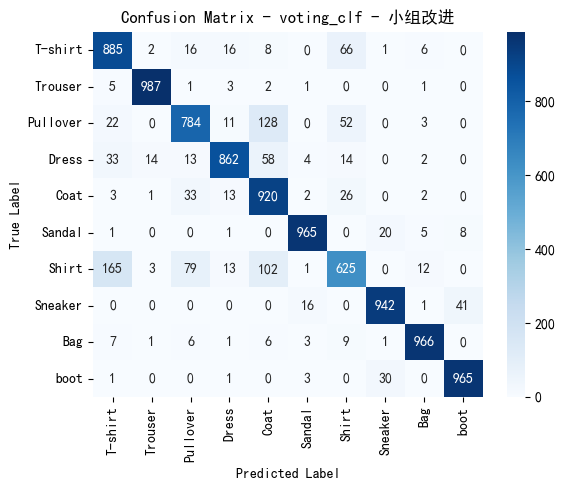

In [44]:
# 定义投票分类器
name = "voting_clf"
writer = "小组改进"
voting_clf = VotingClassifier(estimators=[('RandomForestModel', RandomForestModel), ('MLP_Model', MLP_Model)], voting='soft')

# 训练投票分类器
voting_clf.fit(X_train, y_train)

# 评估模型
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Voting Classifier Accuracy: {accuracy:.2f}")

# 打印分类报告及可视化混淆矩阵
printClassificationReport(name, accuracy)
cm = confusion_matrix(y_test, y_pred)
printConfusionMatrix(name, writer, cm)

可以看到，利用集成学习——投票法预测准确率相对基模型仅提升1%，主要分类错误仍集中于Shirt、Coat、Pullover。我们认为主要原因在于选取的基模型对于这几类的分类效果较差，基于第四部分中多种模型对这几类预测效果差的这一特性，利用这些模型作为基模型使用投票法似乎难以显著提高准确率。

### 改进（二） 基于Pytorch的CNN
CNN 是专为处理具有网格结构数据（如图像）而设计的深度学习模型，核心优势在于自动提取空间特征。

通过以下组件实现：

    卷积层（Convolutional Layer）：
        卷积核（Kernel/Filter）：滑动窗口，自动提取局部特征（如边缘、纹理）。
        参数共享：同一卷积核应用于整个图像，大幅减少参数量。
        特征图（Feature Map）：卷积操作的输出，每个通道对应一种特征。
    激活函数（Activation）
        常用 ReLU（Rectified Linear Unit）：引入非线性，增强模型表达能力。
    池化层（Pooling Layer）
        常用最大池化（Max Pooling）：降低特征图尺寸，减少计算量并增强平移不变性。
    全连接层（Fully Connected Layer）
        将提取的特征映射到分类空间（如 10 个类别对应 10 个输出神经元）。

<div align="center"><img src="./images/CNN_principle.png" width="450" height="300"></div>
<div align="center">CNN卷积神经网络结构图</div>


CNN的优势明显，其参数效率高，卷积层的参数远少于全连接层，适合处理高维数据，另外其无需手动设计特征，模型可直接从原始像素学习并提取特征，同时它对图像中的目标位置变化不敏感。

CNN的大致实现包括数据准备；定义模型架构，使用nn.Module创建自定义网络类，典型结构是卷积层 → ReLU → 池化层 → 全连接层；初始化模型、损失函数和优化器；训练模型，主要包含前向传播计算预测值、反向传播计算梯度并更新参数；最后进行模型评估。

Epoch 1/10, Loss: 0.4713
Epoch 2/10, Loss: 0.3009
Epoch 3/10, Loss: 0.2555
Epoch 4/10, Loss: 0.2242
Epoch 5/10, Loss: 0.1997
Epoch 6/10, Loss: 0.1768
Epoch 7/10, Loss: 0.1554
Epoch 8/10, Loss: 0.1365
Epoch 9/10, Loss: 0.1222
Epoch 10/10, Loss: 0.1046

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.88      0.88      0.88      1000
           3       0.92      0.94      0.93      1000
           4       0.92      0.87      0.89      1000
           5       0.99      0.98      0.98      1000
           6       0.80      0.80      0.80      1000
           7       0.95      0.98      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.

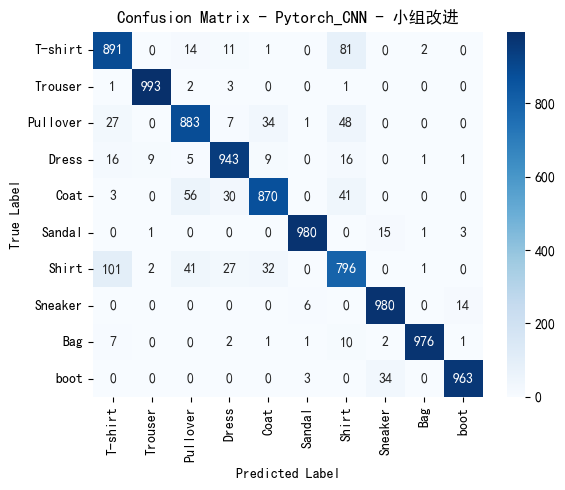

In [47]:
# 定义CNN模型
name = "Pytorch_CNN"
writer = "小组改进"
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 输入通道1，输出通道32
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (img_size//4) * (img_size//4), 128)
        self.fc2 = nn.Linear(128, len(np.unique(y_train)))  # 输出层大小为类别数

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * (img_size//4) * (img_size//4))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')
    
# 评估模型
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 打印分类报告（精确率、召回率、F1分数）
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

accuracy = accuracy_score(all_labels, all_preds)
results[name] = {
    "accuracy": accuracy
}

# 打印混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
printConfusionMatrix(name, writer, cm)

可以看出，CNN模型对shirt、coat、pullover的分类效果有了显著提升，促使其准确率得到显著提升。我们认为主要原因在于CNN卷积神经网络模型的特性，该模型通过卷积层和池化层实现参数共享和降维对于图像分类、目标检测等数据具有局部相关性和空间结构的场景表现较好，是图像学习的不二之选。

### 改进（三）降维及调参的尝试
项目实现过程中，为了提高模型的准确率，我们还尝试了PCA降维及调参与正则化等办法。

我们发现PCA降维方法不仅没有提高部分模型的训练效果反而使它们的准确率降低，我们认为原因可能是由于PCA是线性降维方法，主要保留方差最大的方向，但这些方向未必是分类最有用的方向。对于项目中的图像数据，PCA降维后反而可能丢失区分不同类别的重要细节。项目数据集像素点之间的冗余并不算特别高，使用降维方法的效果有限。

对于调参与正则化方法，我们测试后发现最优参数下模型的准确率与之前的准确率几乎没变化，我们认为调参方法加大了训练强度，但得到的回报太低，不值得。

In [50]:
# 使用PCA进行降维
pca = PCA(n_components=0.95)  # 保留95%的方差
X_reduced = pca.fit_transform(X_train)

# 划分训练集和测试集
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(X_reduced, y_train, test_size=0.2, random_state=42)

# 创建支持向量机分类器
SVC_Model = SVC(kernel='linear', random_state=42)

# 训练模型
SVC_Model.fit(pca_X_train, pca_y_train)

# 进行预测
pca_y_pred = SVC_Model.predict(pca_X_test)
pca_accuracy = accuracy_score(pca_y_test, pca_y_pred)
print(f"SVC with PCA Accuracy: {pca_accuracy:.2f}")

SVC with PCA Accuracy: 0.86


SVC降维前准确率0.86，降维后准确率0.85

In [52]:
# 定义模型和参数网格
RFC = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# 使用网格搜索进行调参
grid_search = GridSearchCV(estimator=RFC, param_grid=param_grid, 
                           scoring='accuracy', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数和模型性能
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

# 评估最佳模型
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Best Random Forest Accuracy: {accuracy:.4f}")


Best parameters found:  {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Accuracy: 0.8857


随机森林调参前准确率为0.8846，调参后准确率为0.8857
训练时间增加了数倍，我们认为不划算

## 六、各模型对比与分析


模型准确率对比：
RandomForest             0.8846
LogesticRegression       0.8528
SVM                      0.8571
DecisionTree             0.7962
MLP                      0.8842
KNC                      0.8589
voting_clf               0.8901
Pytorch_CNN              0.9275


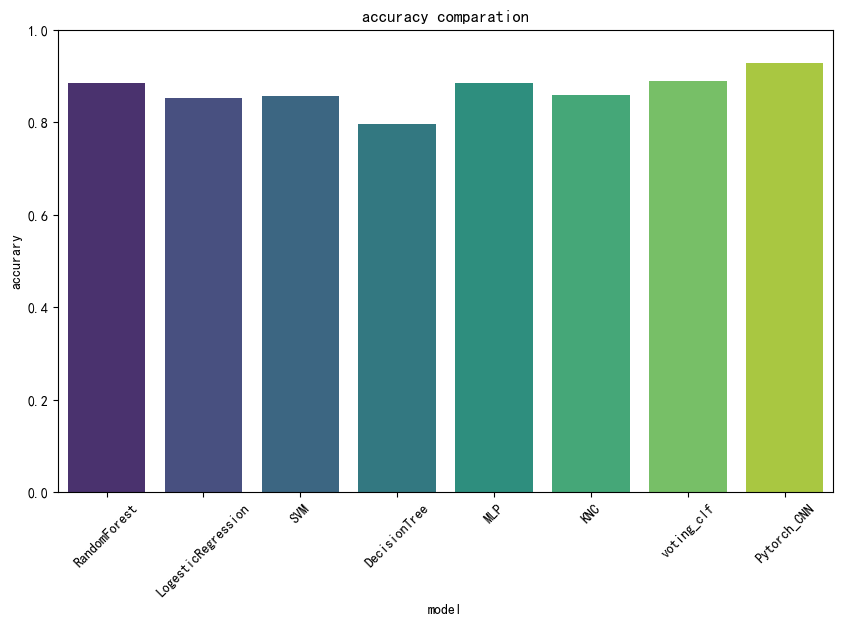

In [55]:
# 汇总各模型准确率
print("\n模型准确率对比：")
accuracies = []
for name in models_name:
    print(f"{name:<25}{results[name]['accuracy']:.4f}")
    accuracies.append(results[name]['accuracy'])

# 绘制柱状图展示准确率
plt.figure(figsize=(10, 6))
sns.barplot(x=models_name, y=accuracies, hue=models_name, palette='viridis')
plt.title('accuracy comparation')
plt.xlabel('model')
plt.ylabel('accurary')
plt.ylim(0, 1)  # 设置y轴范围为0到1
plt.xticks(rotation=45)
plt.show()

由上述对比图可以看出，CNN方法的准确度最高，投票法次之，随机森林法与多层感知机并列第三。  
具体原因在前面已有分析，即CNN法更适用于图像分类；投票法结合了多种基模型的决策投票得出最佳结果；